# Running SPUD with Profile and and Visits as Domains

In [13]:
#Import necessary libraries

import sys
import os
import importlib

# Make it so you can get modules from the parent directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

import test_manifold_algorithms as tma
from MASH import MASH
import SPUD
importlib.reload(SPUD) #makes sure that you're always using the updated code
from SPUD import SPUD
from temporal_progression_comparisons import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [14]:
scans = pd.read_csv(r"..\..\CSV Files\ADNI_Embedded_Features.csv")
truncate_ids = lambda id: int(id[-4:])
scans.Patient_ID = scans.Patient_ID.apply(truncate_ids)

In [15]:
LABEL_VARIABLE = "DX_bl"
SAMPLE_SIZE = 5

profile_raw = pd.read_excel(r"..\..\CSV Files\Profile Variables 2024-07-31.xlsx", index_col="RID")
scans_raw = pd.read_csv(r"..\..\CSV Files\ADNI_Embedded_Features.csv")
truncate_ids = lambda id: int(id[-4:])
scans_raw.Patient_ID = scans_raw.Patient_ID.apply(truncate_ids)

#drop empty rows
profile_raw.dropna(how="all", inplace=True)
scans_raw.dropna(how="all", inplace=True)

#if all of the data is to be used, simply set the sample size to be all of the available patients
if SAMPLE_SIZE == "all":
    SAMPLE_SIZE = len(profile_raw)

#remap and delete a few variables, might make part of the merge later to be more steamlined on when to map and delete stuff
profile_raw['DX_bl'] = profile_raw['DX_bl'].map({'CN': 0, 'SMC': 1, 'EMCI': 2, 'LMCI': 3, 'AD': 4, 'NaN': -4, -4: -4})
profile_raw['PTMARRY'] = profile_raw['PTMARRY'].map({'Married': 1, 'Widowed': 2, 'Divorced': 3, 'Never married': 4, 'Unknown': -4, 'NaN': -4, -4: -4})

profile = profile_raw.drop(columns = [LABEL_VARIABLE, "PTRACCAT"])
scans = scans_raw.drop(columns = ["Date", "Labels"]).set_index("Patient_ID").sort_index()

label_column = profile_raw[LABEL_VARIABLE].fillna(-4)

In [16]:
#take the SAMPLE_SIZE of people from the scans this time just since they have a weird range
sample_rids = list(set(scans.index.values)) #set will quickly get the unique rid values there
sample_rids.sort()
sample_rids = sample_rids[:SAMPLE_SIZE]

#domain_a = profile.loc[(profile.index >= min(sample_rids)) & (profile.index <= max(sample_rids))]
domain_a = np.array(profile.loc[min(sample_rids):max(sample_rids)]).astype(float)

domain_b = np.array(scans).astype(float)

In [17]:
#build the anchors list from the indecies of the corresponding RID labels
profile_anchors = list(profile.loc[min(sample_rids):max(sample_rids)].index.values)
scans_anchors = list(scans.index.values)

#make an anchor for every visit with its corresponding profile
#a more generic anchor generator, maybe to use later
anchors = []
for i, rid1 in enumerate(profile_anchors):
    # Compare it with each item in list2
    for j, rid2 in enumerate(scans_anchors):
        # If they match, store the indices as a pair
        if rid1 == rid2:
            anchors.append([i, j])

#build the labels list
domain_a_labels = label_column[profile_anchors]
domain_b_labels = label_column[scans_anchors]
labels = pd.concat([domain_a_labels, domain_b_labels])


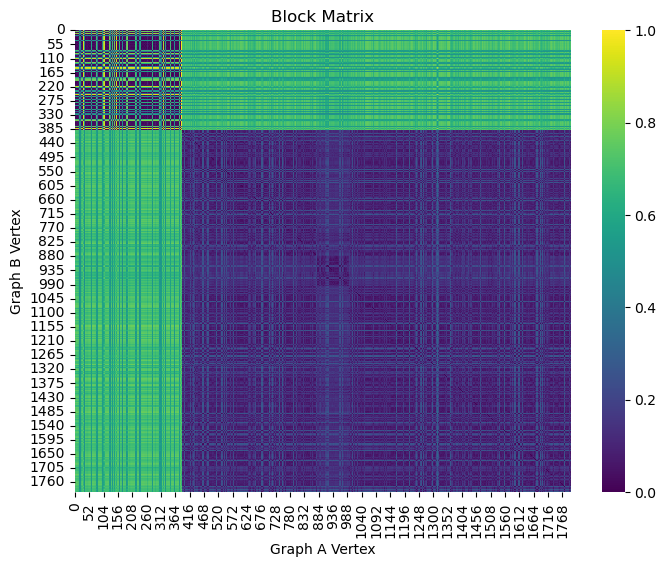

c:\Users\jcory\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Cross Embedding: 0.24728294621786112
Can't compute FOSCTTM with different domain shapes.


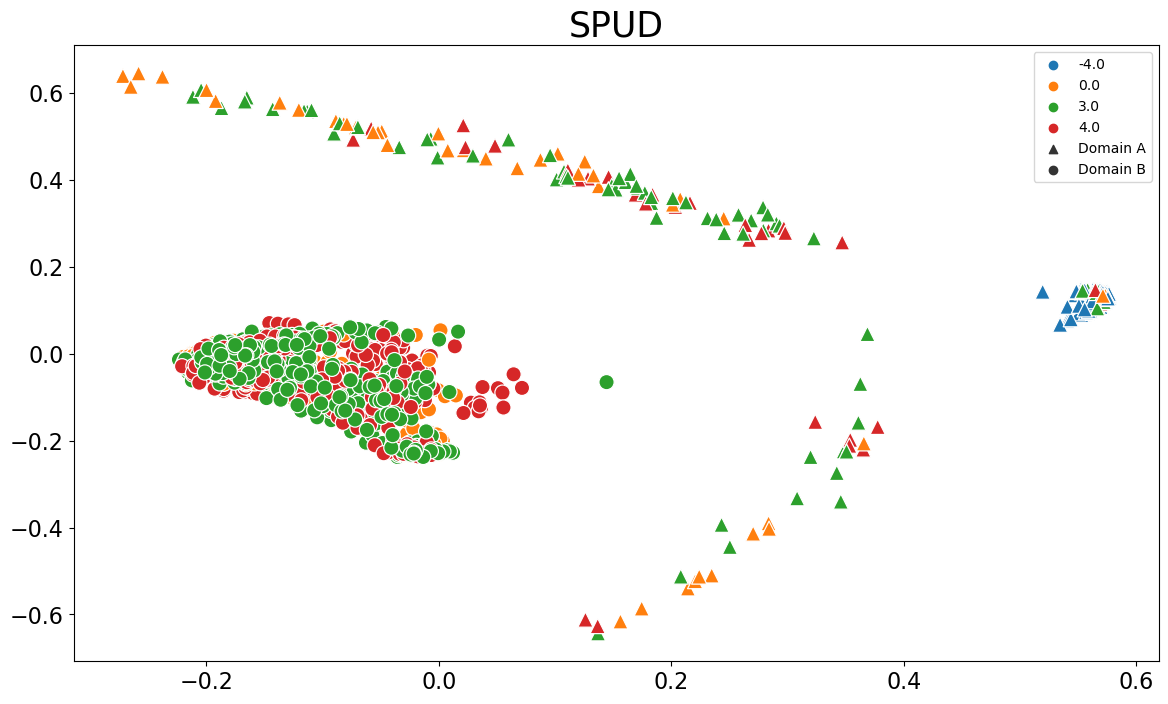

In [18]:
#Create the merged values --> This will take up the rest of your day
ps_spud = SPUD(n_pca = 10)
ps_spud.fit(domain_a, domain_b, known_anchors = anchors)
ps_spud.plot_heat_map()
#ps_spud.plot_graphs()
ps_spud.plot_emb(labels = labels, show_anchors = False, show_lines = False, n_comp = 2)